### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

## Helper Functions for Plotting Predictions and Calculating RMSE

In [9]:
def plot(test, predctions):
  plt.plot(test, color='red')
  plt.plot(predctions, color='blue')
  plt.legend()
  plt.show()

def return_rmse(test, predctions):
  rmse = math.sqrt(mean_squared_error(test, predctions))
  print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [10]:
df = pd.read_csv('/content/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [12]:
train_data = df[:'2016'].iloc[:,1:2].values
test_data = df['2017':].iloc[:,1:2].values

Visualizing the data

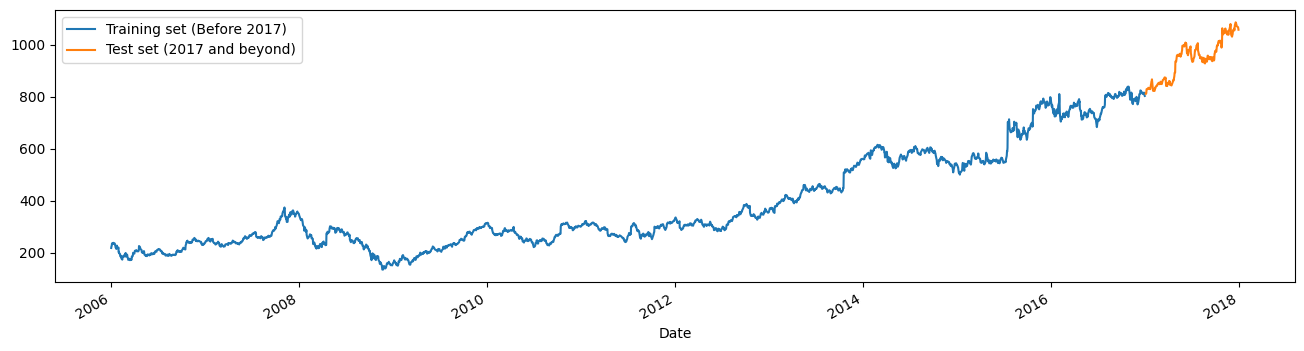

In [20]:
df['High'][:'2016'].plot(figsize=(16,4), legend=True)
df['High']['2017':].plot(figsize=(16,4), legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.show()

## Data Preprocessing

Scaling the training set

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
training_scaled = scaler.fit_transform(train_data)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [30]:
x_train, y_train = [], []

for i in range(60,2768):
  x_train.append(training_scaled[i-60: i,0])
  y_train.append(training_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [38]:
x_train

array([[0.11819421, 0.12763782, 0.12948394, ..., 0.07273708, 0.07711097,
        0.09213553],
       [0.12763782, 0.12948394, 0.14296061, ..., 0.07711097, 0.09213553,
        0.08823028],
       [0.12948394, 0.14296061, 0.14501974, ..., 0.09213553, 0.08823028,
        0.08706581],
       ...,
       [0.94964356, 0.95384703, 0.95668721, ..., 0.96033685, 0.96019484,
        0.9673379 ],
       [0.95384703, 0.95668721, 0.95447187, ..., 0.96019484, 0.9673379 ,
        0.96354625],
       [0.95668721, 0.95447187, 0.95305178, ..., 0.9673379 , 0.96354625,
        0.95278196]])

In [48]:
print(x_train.shape[1])

60


In [49]:
X_train_reshaped = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))

## LSTM Model

In [52]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)),
    Dropout(0.2),

    LSTM(units=50, return_sequences=True),
    Dropout(0.2),

    LSTM(units=50, return_sequences=True),
    Dropout(0.2),

    LSTM(units=50),
    Dropout(0.2),

    Dense(1)
])

model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.fit(x_train, y_train, epochs = 3, batch_size=32, verbose=2)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 - 16s - 184ms/step - loss: 0.0130
Epoch 2/3
85/85 - 10s - 122ms/step - loss: 0.0062
Epoch 3/3
85/85 - 10s - 120ms/step - loss: 0.0047



## Make preductuion with LSTM model

In [57]:
full_data = pd.concat((df['High'][:'2016'], df['High']['2017':]), axis=0)
inputs = full_data[len(full_data)-len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

Visualizing the results

In [62]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


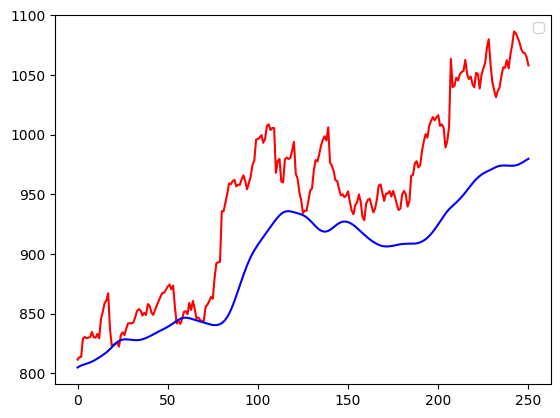

In [65]:
plot(test_data,predicted_stock_price)

Evaluating LSMT Model

In [67]:
return_rmse(test_data,predicted_stock_price)

The root mean squared error is 59.90451321477496.


## GRU Model

In [69]:
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'),
    Dropout(0.2),

    GRU(units=50, return_sequences=True, activation='tanh'),
    Dropout(0.2),

    GRU(units=50, return_sequences=True, activation='tanh'),
    Dropout(0.2),

    GRU(units=50, activation='tanh'),
    Dropout(0.2),

    Dense(1)
])

model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs = 3, batch_size=1, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/3
2708/2708 - 151s - 56ms/step - loss: 0.0056
Epoch 2/3
2708/2708 - 201s - 74ms/step - loss: 0.0022
Epoch 3/3
2708/2708 - 203s - 75ms/step - loss: 0.0019



## Make preductuion with GRU model

In [72]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = model.predict(X_test)
GRU_predicted_stock_price = scaler.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Visualizing the Results

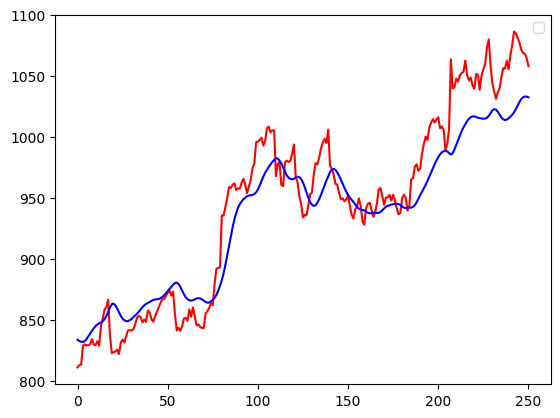

In [73]:
plot(test_data,GRU_predicted_stock_price)

Evaluating GRU Model

In [74]:
return_rmse(test_data,GRU_predicted_stock_price)

The root mean squared error is 26.390924869857663.
